# Asthma Prediction Model
This notebook builds a machine learning model to predict asthma and asthma control levels

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data

In [2]:
# Load the dataset
df = pd.read_csv('synthetic_asthma_dataset.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nDataset info:")
print(df.info())
print(f"\nTarget variable distribution:")
print(df['Has_Asthma'].value_counts())

Dataset shape: (10000, 17)

First few rows:
   Patient_ID  Age  Gender   BMI Smoking_Status  Family_History Allergies  \
0  ASTH100000   52  Female  27.6         Former               1       NaN   
1  ASTH100001   15    Male  24.6         Former               0      Dust   
2  ASTH100002   72  Female  17.6          Never               0       NaN   
3  ASTH100003   61    Male  16.8          Never               0  Multiple   
4  ASTH100004   21    Male  30.2          Never               0       NaN   

  Air_Pollution_Level Physical_Activity_Level Occupation_Type Comorbidities  \
0            Moderate               Sedentary         Outdoor      Diabetes   
1                 Low                Moderate          Indoor          Both   
2            Moderate                Moderate          Indoor           NaN   
3                High               Sedentary         Outdoor          Both   
4            Moderate                  Active          Indoor           NaN   

   Medication_Adhe

## Comprehensive Data Visualization

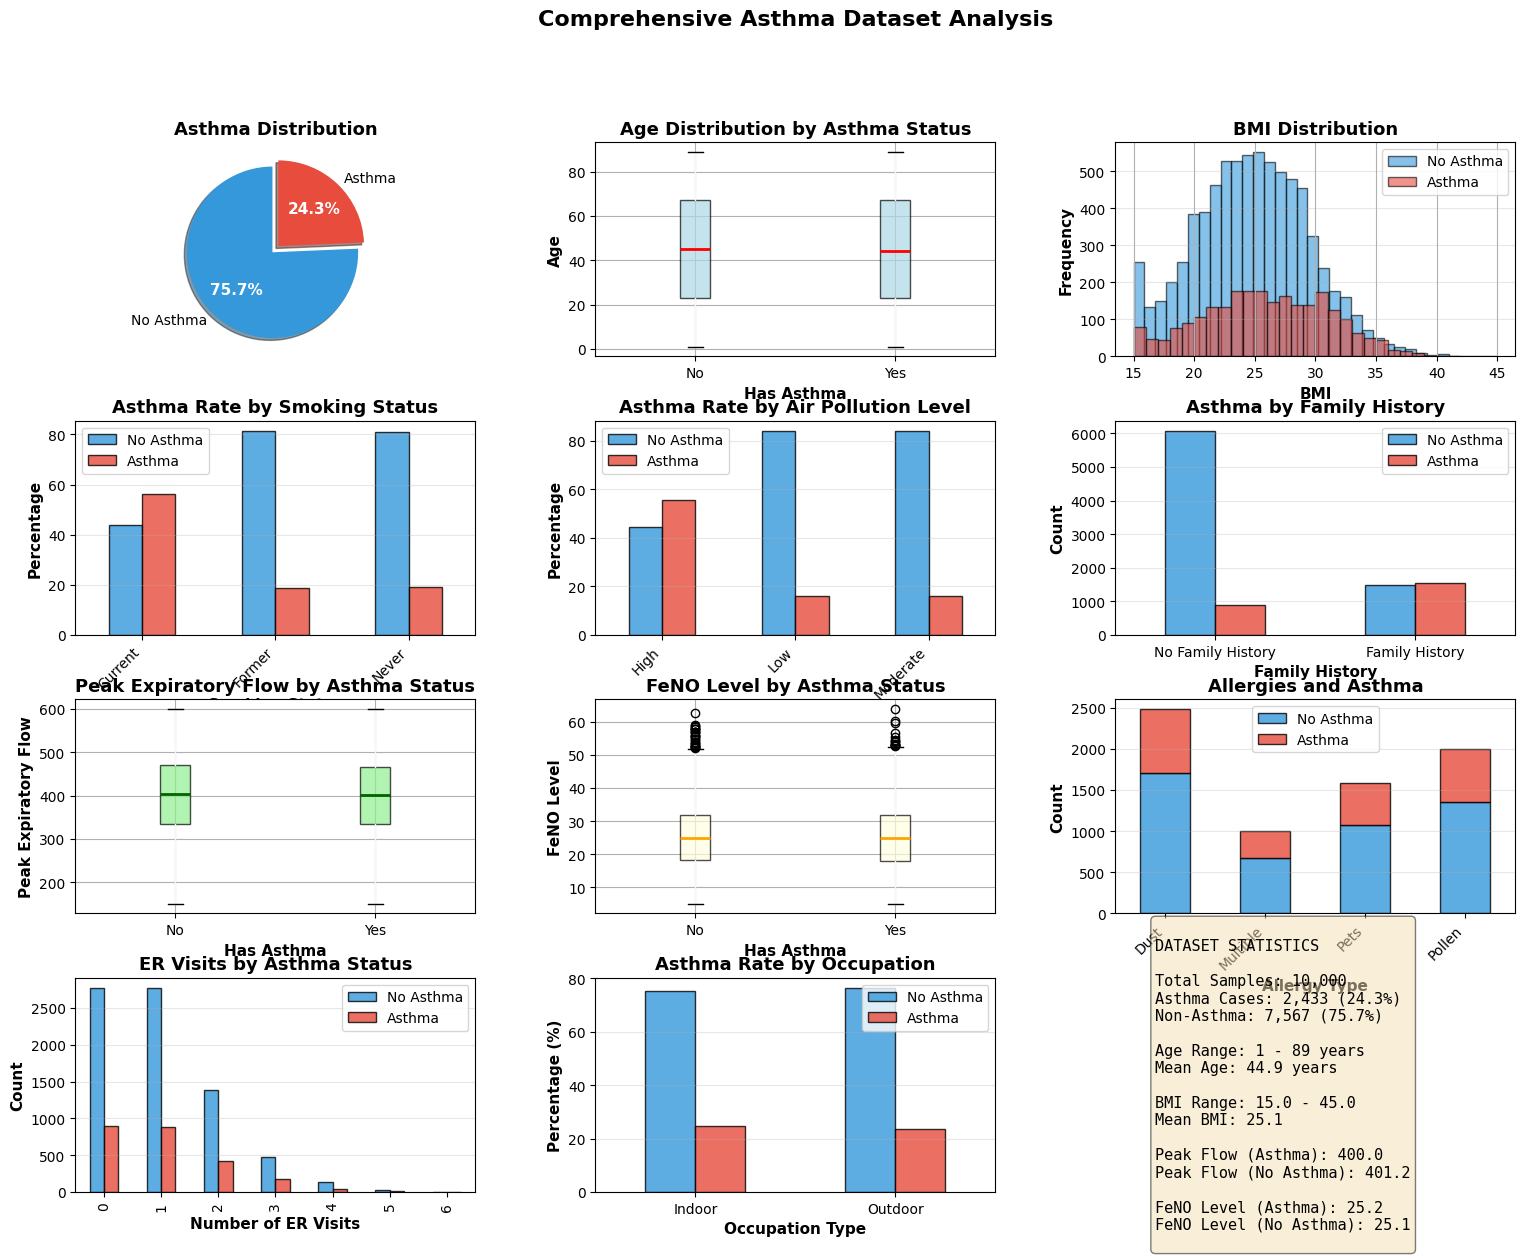

In [3]:
# Set visualization style
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100

# Create comprehensive visualizations
fig = plt.figure(figsize=(18, 14))
gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)

# 1. Target variable distribution
ax1 = fig.add_subplot(gs[0, 0])
asthma_counts = df['Has_Asthma'].value_counts()
colors = ['#3498db', '#e74c3c']
wedges, texts, autotexts = ax1.pie(asthma_counts.values, labels=['No Asthma', 'Asthma'], 
                                     autopct='%1.1f%%', colors=colors, startangle=90,
                                     explode=(0.05, 0.05), shadow=True)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_weight('bold')
    autotext.set_fontsize(11)
ax1.set_title('Asthma Distribution', fontsize=13, weight='bold')

# 2. Age distribution by Asthma status
ax2 = fig.add_subplot(gs[0, 1])
df.boxplot(column='Age', by='Has_Asthma', ax=ax2, patch_artist=True,
           boxprops=dict(facecolor='lightblue', alpha=0.7),
           medianprops=dict(color='red', linewidth=2))
ax2.set_xlabel('Has Asthma', fontsize=11, weight='bold')
ax2.set_ylabel('Age', fontsize=11, weight='bold')
ax2.set_title('Age Distribution by Asthma Status', fontsize=13, weight='bold')
ax2.set_xticklabels(['No', 'Yes'])
plt.suptitle('')  # Remove the automatic title

# 3. BMI distribution
ax3 = fig.add_subplot(gs[0, 2])
df[df['Has_Asthma']==0]['BMI'].hist(bins=30, alpha=0.6, label='No Asthma', 
                                      color='#3498db', ax=ax3, edgecolor='black')
df[df['Has_Asthma']==1]['BMI'].hist(bins=30, alpha=0.6, label='Asthma', 
                                      color='#e74c3c', ax=ax3, edgecolor='black')
ax3.set_xlabel('BMI', fontsize=11, weight='bold')
ax3.set_ylabel('Frequency', fontsize=11, weight='bold')
ax3.set_title('BMI Distribution', fontsize=13, weight='bold')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. Smoking Status
ax4 = fig.add_subplot(gs[1, 0])
smoking_asthma = pd.crosstab(df['Smoking_Status'], df['Has_Asthma'], normalize='index') * 100
smoking_asthma.plot(kind='bar', ax=ax4, color=colors, alpha=0.8, edgecolor='black')
ax4.set_xlabel('Smoking Status', fontsize=11, weight='bold')
ax4.set_ylabel('Percentage', fontsize=11, weight='bold')
ax4.set_title('Asthma Rate by Smoking Status', fontsize=13, weight='bold')
ax4.legend(['No Asthma', 'Asthma'])
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha='right')
ax4.grid(axis='y', alpha=0.3)

# 5. Air Pollution Level
ax5 = fig.add_subplot(gs[1, 1])
pollution_asthma = pd.crosstab(df['Air_Pollution_Level'], df['Has_Asthma'], normalize='index') * 100
pollution_asthma.plot(kind='bar', ax=ax5, color=colors, alpha=0.8, edgecolor='black')
ax5.set_xlabel('Air Pollution Level', fontsize=11, weight='bold')
ax5.set_ylabel('Percentage', fontsize=11, weight='bold')
ax5.set_title('Asthma Rate by Air Pollution Level', fontsize=13, weight='bold')
ax5.legend(['No Asthma', 'Asthma'])
ax5.set_xticklabels(ax5.get_xticklabels(), rotation=45, ha='right')
ax5.grid(axis='y', alpha=0.3)

# 6. Family History
ax6 = fig.add_subplot(gs[1, 2])
family_history = pd.crosstab(df['Family_History'], df['Has_Asthma'])
family_history.plot(kind='bar', ax=ax6, color=colors, alpha=0.8, edgecolor='black')
ax6.set_xlabel('Family History', fontsize=11, weight='bold')
ax6.set_ylabel('Count', fontsize=11, weight='bold')
ax6.set_title('Asthma by Family History', fontsize=13, weight='bold')
ax6.legend(['No Asthma', 'Asthma'])
ax6.set_xticklabels(['No Family History', 'Family History'], rotation=0)
ax6.grid(axis='y', alpha=0.3)

# 7. Peak Expiratory Flow
ax7 = fig.add_subplot(gs[2, 0])
df.boxplot(column='Peak_Expiratory_Flow', by='Has_Asthma', ax=ax7, patch_artist=True,
           boxprops=dict(facecolor='lightgreen', alpha=0.7),
           medianprops=dict(color='darkgreen', linewidth=2))
ax7.set_xlabel('Has Asthma', fontsize=11, weight='bold')
ax7.set_ylabel('Peak Expiratory Flow', fontsize=11, weight='bold')
ax7.set_title('Peak Expiratory Flow by Asthma Status', fontsize=13, weight='bold')
ax7.set_xticklabels(['No', 'Yes'])
plt.suptitle('')

# 8. FeNO Level
ax8 = fig.add_subplot(gs[2, 1])
df.boxplot(column='FeNO_Level', by='Has_Asthma', ax=ax8, patch_artist=True,
           boxprops=dict(facecolor='lightyellow', alpha=0.7),
           medianprops=dict(color='orange', linewidth=2))
ax8.set_xlabel('Has Asthma', fontsize=11, weight='bold')
ax8.set_ylabel('FeNO Level', fontsize=11, weight='bold')
ax8.set_title('FeNO Level by Asthma Status', fontsize=13, weight='bold')
ax8.set_xticklabels(['No', 'Yes'])
plt.suptitle('')

# 9. Allergies
ax9 = fig.add_subplot(gs[2, 2])
allergies_counts = df.groupby(['Allergies', 'Has_Asthma']).size().unstack(fill_value=0)
allergies_counts.plot(kind='bar', stacked=True, ax=ax9, color=colors, alpha=0.8, edgecolor='black')
ax9.set_xlabel('Allergy Type', fontsize=11, weight='bold')
ax9.set_ylabel('Count', fontsize=11, weight='bold')
ax9.set_title('Allergies and Asthma', fontsize=13, weight='bold')
ax9.legend(['No Asthma', 'Asthma'])
ax9.set_xticklabels(ax9.get_xticklabels(), rotation=45, ha='right')
ax9.grid(axis='y', alpha=0.3)

# 10. ER Visits distribution
ax10 = fig.add_subplot(gs[3, 0])
er_data = df.groupby(['Number_of_ER_Visits', 'Has_Asthma']).size().unstack(fill_value=0)
er_data.plot(kind='bar', ax=ax10, color=colors, alpha=0.8, edgecolor='black')
ax10.set_xlabel('Number of ER Visits', fontsize=11, weight='bold')
ax10.set_ylabel('Count', fontsize=11, weight='bold')
ax10.set_title('ER Visits by Asthma Status', fontsize=13, weight='bold')
ax10.legend(['No Asthma', 'Asthma'])
ax10.grid(axis='y', alpha=0.3)

# 11. Occupation Type
ax11 = fig.add_subplot(gs[3, 1])
occupation = pd.crosstab(df['Occupation_Type'], df['Has_Asthma'], normalize='index') * 100
occupation.plot(kind='bar', ax=ax11, color=colors, alpha=0.8, edgecolor='black')
ax11.set_xlabel('Occupation Type', fontsize=11, weight='bold')
ax11.set_ylabel('Percentage (%)', fontsize=11, weight='bold')
ax11.set_title('Asthma Rate by Occupation', fontsize=13, weight='bold')
ax11.legend(['No Asthma', 'Asthma'])
ax11.set_xticklabels(ax11.get_xticklabels(), rotation=0)
ax11.grid(axis='y', alpha=0.3)

# 12. Statistics summary
ax12 = fig.add_subplot(gs[3, 2])
ax12.axis('off')
stats_text = f"""
DATASET STATISTICS

Total Samples: {len(df):,}
Asthma Cases: {(df['Has_Asthma']==1).sum():,} ({(df['Has_Asthma']==1).sum()/len(df)*100:.1f}%)
Non-Asthma: {(df['Has_Asthma']==0).sum():,} ({(df['Has_Asthma']==0).sum()/len(df)*100:.1f}%)

Age Range: {df['Age'].min():.0f} - {df['Age'].max():.0f} years
Mean Age: {df['Age'].mean():.1f} years

BMI Range: {df['BMI'].min():.1f} - {df['BMI'].max():.1f}
Mean BMI: {df['BMI'].mean():.1f}

Peak Flow (Asthma): {df[df['Has_Asthma']==1]['Peak_Expiratory_Flow'].mean():.1f}
Peak Flow (No Asthma): {df[df['Has_Asthma']==0]['Peak_Expiratory_Flow'].mean():.1f}

FeNO Level (Asthma): {df[df['Has_Asthma']==1]['FeNO_Level'].mean():.1f}
FeNO Level (No Asthma): {df[df['Has_Asthma']==0]['FeNO_Level'].mean():.1f}
"""
ax12.text(0.1, 0.5, stats_text, fontsize=11, verticalalignment='center',
          family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Comprehensive Asthma Dataset Analysis', fontsize=16, weight='bold', y=0.995)
plt.show()

## Feature Correlation Analysis

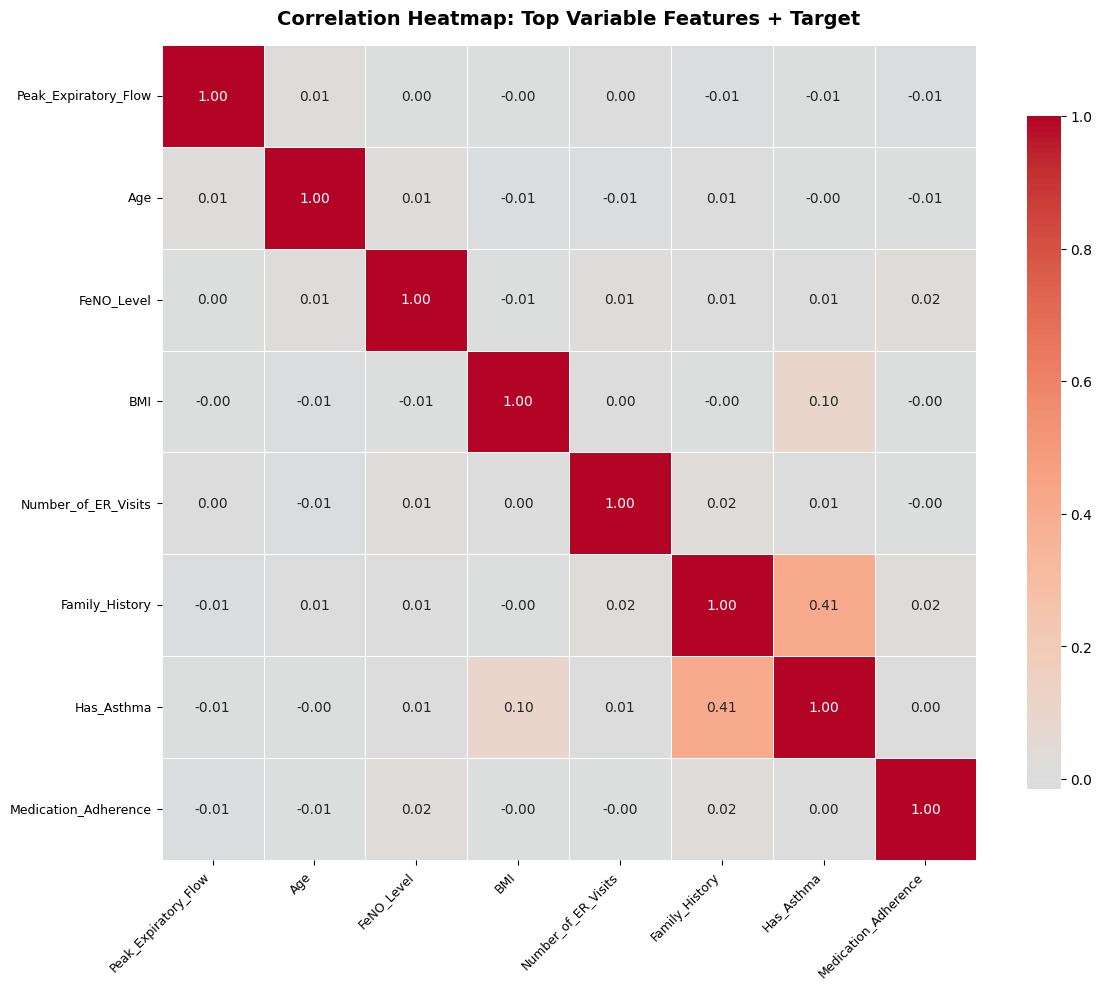

In [4]:
# Visualization 4: Correlation Heatmap of Top Features
plt.figure(figsize=(12, 10))

# FIXED: Use numeric_only=True to exclude Patient_ID and other non-numeric columns
correlation_matrix = df.corr(numeric_only=True)

# Select top features by variance for visualization
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Remove ID-like columns
numeric_cols = [col for col in numeric_cols if not any(x in col.lower() for x in ['id', 'patient'])]

if 'Asthma_Diagnosis' in numeric_cols:
    numeric_cols.remove('Asthma_Diagnosis')

# Calculate variance and select top features
feature_variance = df[numeric_cols].var().sort_values(ascending=False)
top_features = feature_variance.head(min(15, len(feature_variance))).index.tolist()

# Add target variable for correlation analysis
if 'Asthma_Diagnosis' in df.columns:
    top_features.append('Asthma_Diagnosis')

# Get correlation matrix for selected features
corr_subset = df[top_features].corr()

# Create heatmap
sns.heatmap(corr_subset, annot=True, fmt='.2f', cmap='coolwarm', center=0,
           square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})

plt.title('Correlation Heatmap: Top Variable Features + Target', fontsize=14, weight='bold', pad=15)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()

# Print correlation with target
if 'Asthma_Diagnosis' in df.columns:
    target_corr = corr_subset['Asthma_Diagnosis'].drop('Asthma_Diagnosis').sort_values(ascending=False)
    
    print("\n" + "="*80)
    print("CORRELATIONS WITH ASTHMA DIAGNOSIS")
    print("="*80)
    print("\nTop Positive Correlations:")
    print(target_corr.head(5))
    print("\nTop Negative Correlations:")
    print(target_corr.tail(5))
    print("="*80)

## Data Preprocessing

In [5]:
# Drop Patient_ID and Asthma_Control_Level (target for asthma patients only)
df_processed = df.drop(['Patient_ID', 'Asthma_Control_Level'], axis=1)

# Encode categorical variables
categorical_cols = df_processed.select_dtypes(include=['object']).columns
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col])
    label_encoders[col] = le

print(f"Encoded categorical columns: {list(categorical_cols)}")
print(f"\nProcessed data shape: {df_processed.shape}")

Encoded categorical columns: ['Gender', 'Smoking_Status', 'Allergies', 'Air_Pollution_Level', 'Physical_Activity_Level', 'Occupation_Type', 'Comorbidities']

Processed data shape: (10000, 15)


## Exploratory Data Analysis

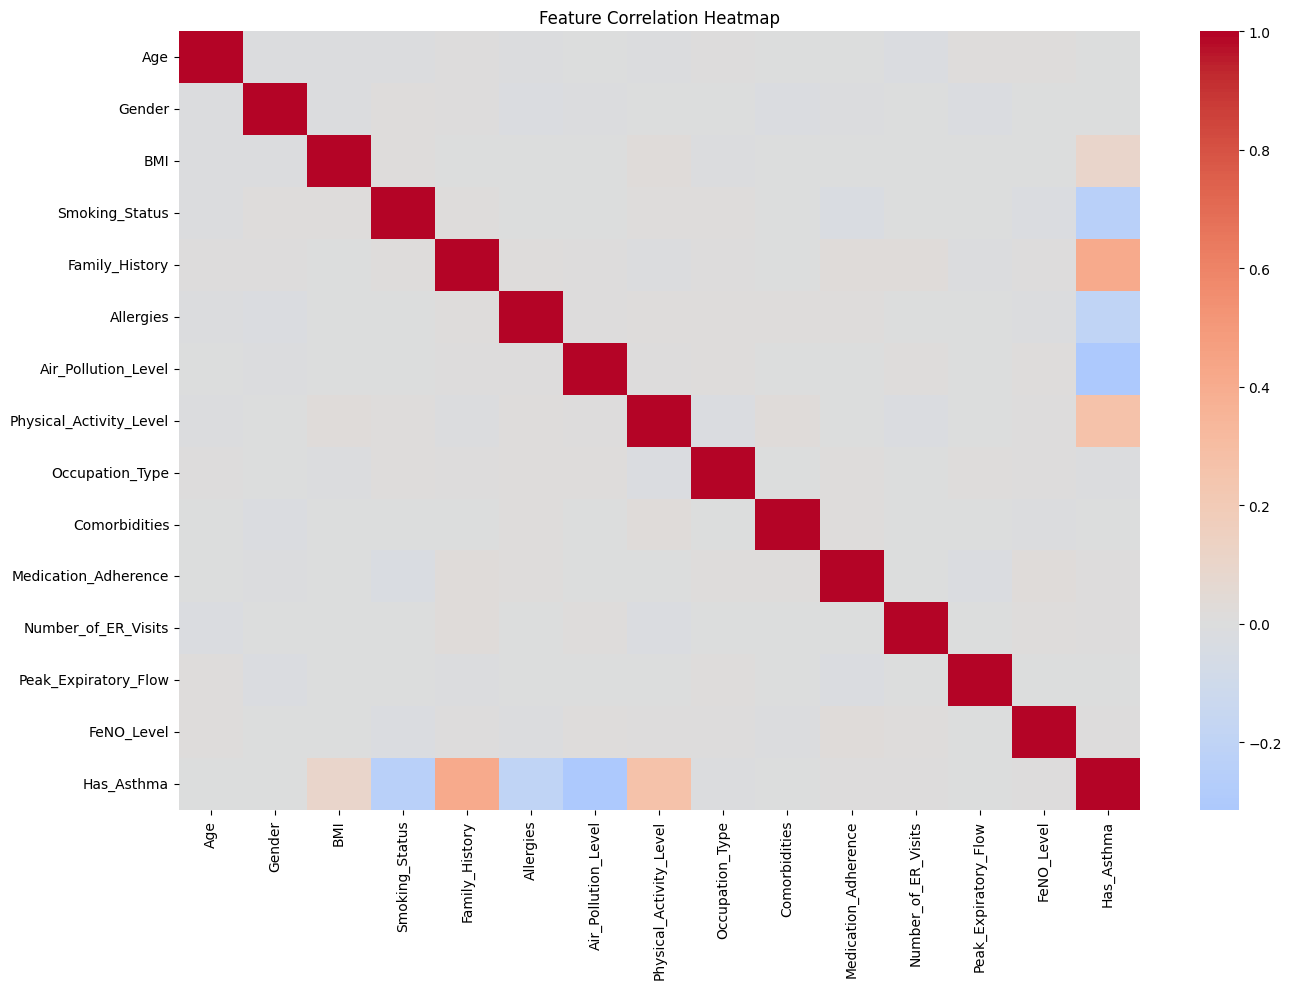


Top features correlated with Has_Asthma:
Has_Asthma                 1.000000
Family_History             0.409531
Physical_Activity_Level    0.265186
BMI                        0.098425
FeNO_Level                 0.007012
Number_of_ER_Visits        0.005781
Medication_Adherence       0.003785
Comorbidities              0.002008
Gender                    -0.002069
Age                       -0.004346
Name: Has_Asthma, dtype: float64


In [6]:
# Correlation heatmap
plt.figure(figsize=(14, 10))
correlation_matrix = df_processed.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, annot=False)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

# Top correlations with Has_Asthma
target_corr = correlation_matrix['Has_Asthma'].sort_values(ascending=False)
print("\nTop features correlated with Has_Asthma:")
print(target_corr.head(10))

## Split Data and Scale Features

In [7]:
# Separate features and target
X = df_processed.drop('Has_Asthma', axis=1)
y = df_processed['Has_Asthma']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")
print(f"Class distribution in training: {y_train.value_counts()}")

Training set: (8000, 14)
Test set: (2000, 14)
Class distribution in training: Has_Asthma
0    6054
1    1946
Name: count, dtype: int64


Logistic Regression Results:
Accuracy: 0.8840
ROC-AUC Score: 0.9449

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      1513
           1       0.79      0.72      0.75       487

    accuracy                           0.88      2000
   macro avg       0.85      0.83      0.84      2000
weighted avg       0.88      0.88      0.88      2000



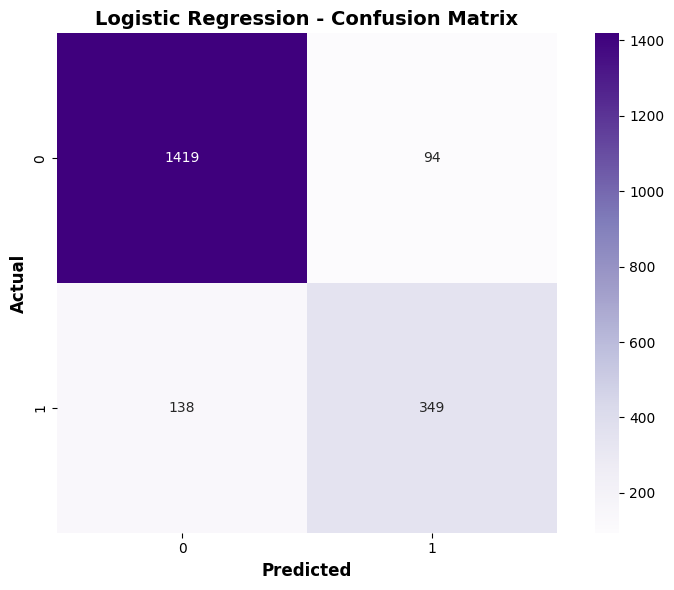

In [8]:
# Train Logistic Regression
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("Logistic Regression Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_lr):.4f}")
print(f"\nClassification Report:\n{classification_report(y_test, y_pred_lr)}")

# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Purples', cbar=True, square=True)
plt.title('Logistic Regression - Confusion Matrix', fontsize=14, weight='bold')
plt.ylabel('Actual', fontsize=12, weight='bold')
plt.xlabel('Predicted', fontsize=12, weight='bold')
plt.tight_layout()
plt.show()

## Model 1: Logistic Regression (Baseline)

## Model 2: Random Forest Classifier

In [10]:
# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("Random Forest Classifier Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")
print(f"\nClassification Report:\n{classification_report(y_test, y_pred_rf)}")

Random Forest Classifier Results:
Accuracy: 0.9985
ROC-AUC Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1513
           1       1.00      0.99      1.00       487

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



## Model 3: Gradient Boosting Classifier

In [11]:
# Train Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=200, max_depth=5, random_state=42)
gb_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_gb = gb_model.predict(X_test_scaled)
y_pred_proba_gb = gb_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("Gradient Boosting Classifier Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_gb):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_gb):.4f}")
print(f"\nClassification Report:\n{classification_report(y_test, y_pred_gb)}")

Gradient Boosting Classifier Results:
Accuracy: 0.9995
ROC-AUC Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1513
           1       1.00      1.00      1.00       487

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



## ROC Curve Comparison

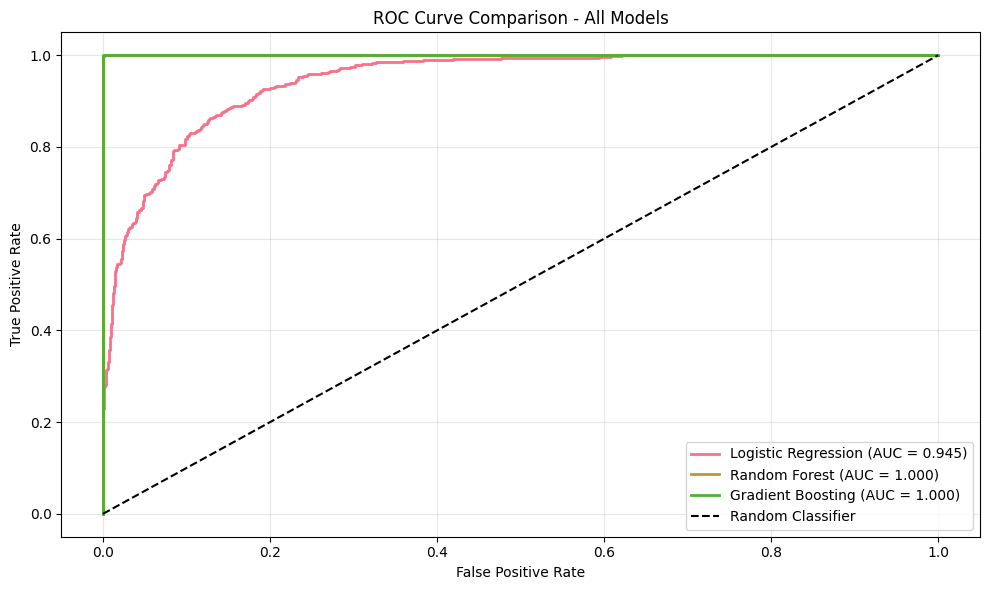

In [12]:
# Plot ROC curves
plt.figure(figsize=(10, 6))

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_pred_proba_gb)

plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_pred_proba_lr):.3f})', linewidth=2)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_pred_proba_rf):.3f})', linewidth=2)
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {roc_auc_score(y_test, y_pred_proba_gb):.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison - All Models')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Confusion Matrix

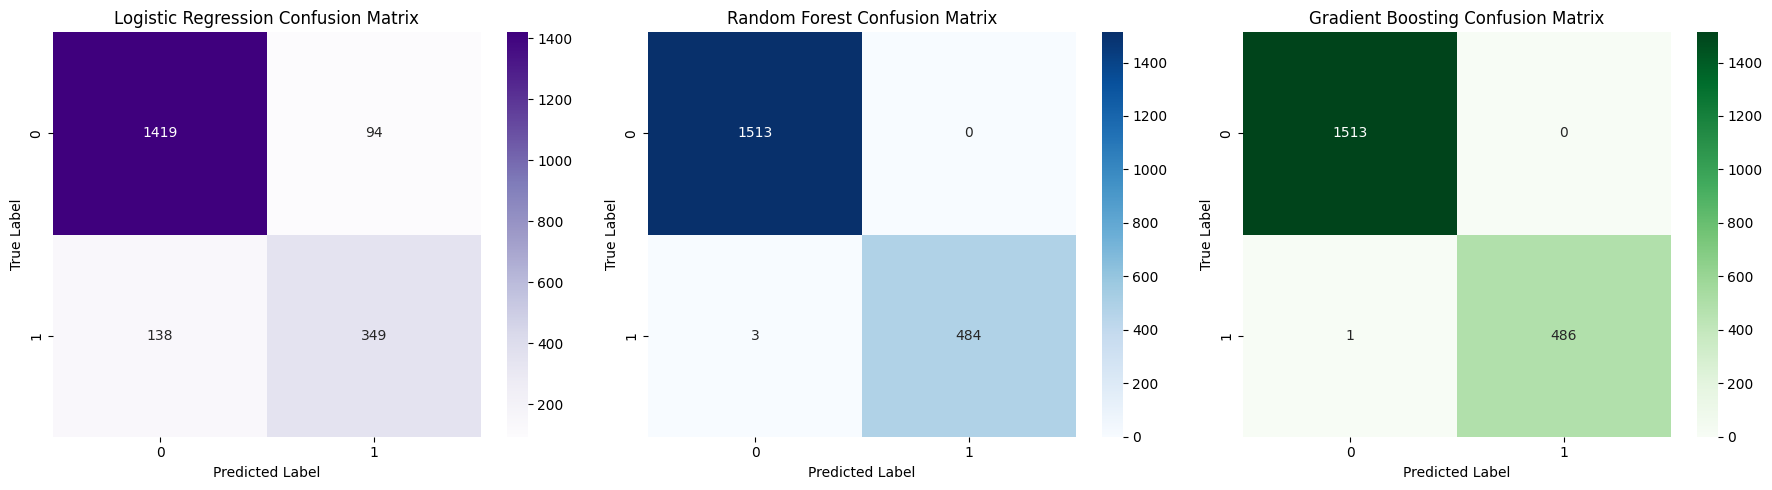

In [13]:
# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Purples', ax=axes[0])
axes[0].set_title('Logistic Regression Confusion Matrix')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Random Forest Confusion Matrix')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

cm_gb = confusion_matrix(y_test, y_pred_gb)
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Greens', ax=axes[2])
axes[2].set_title('Gradient Boosting Confusion Matrix')
axes[2].set_ylabel('True Label')
axes[2].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

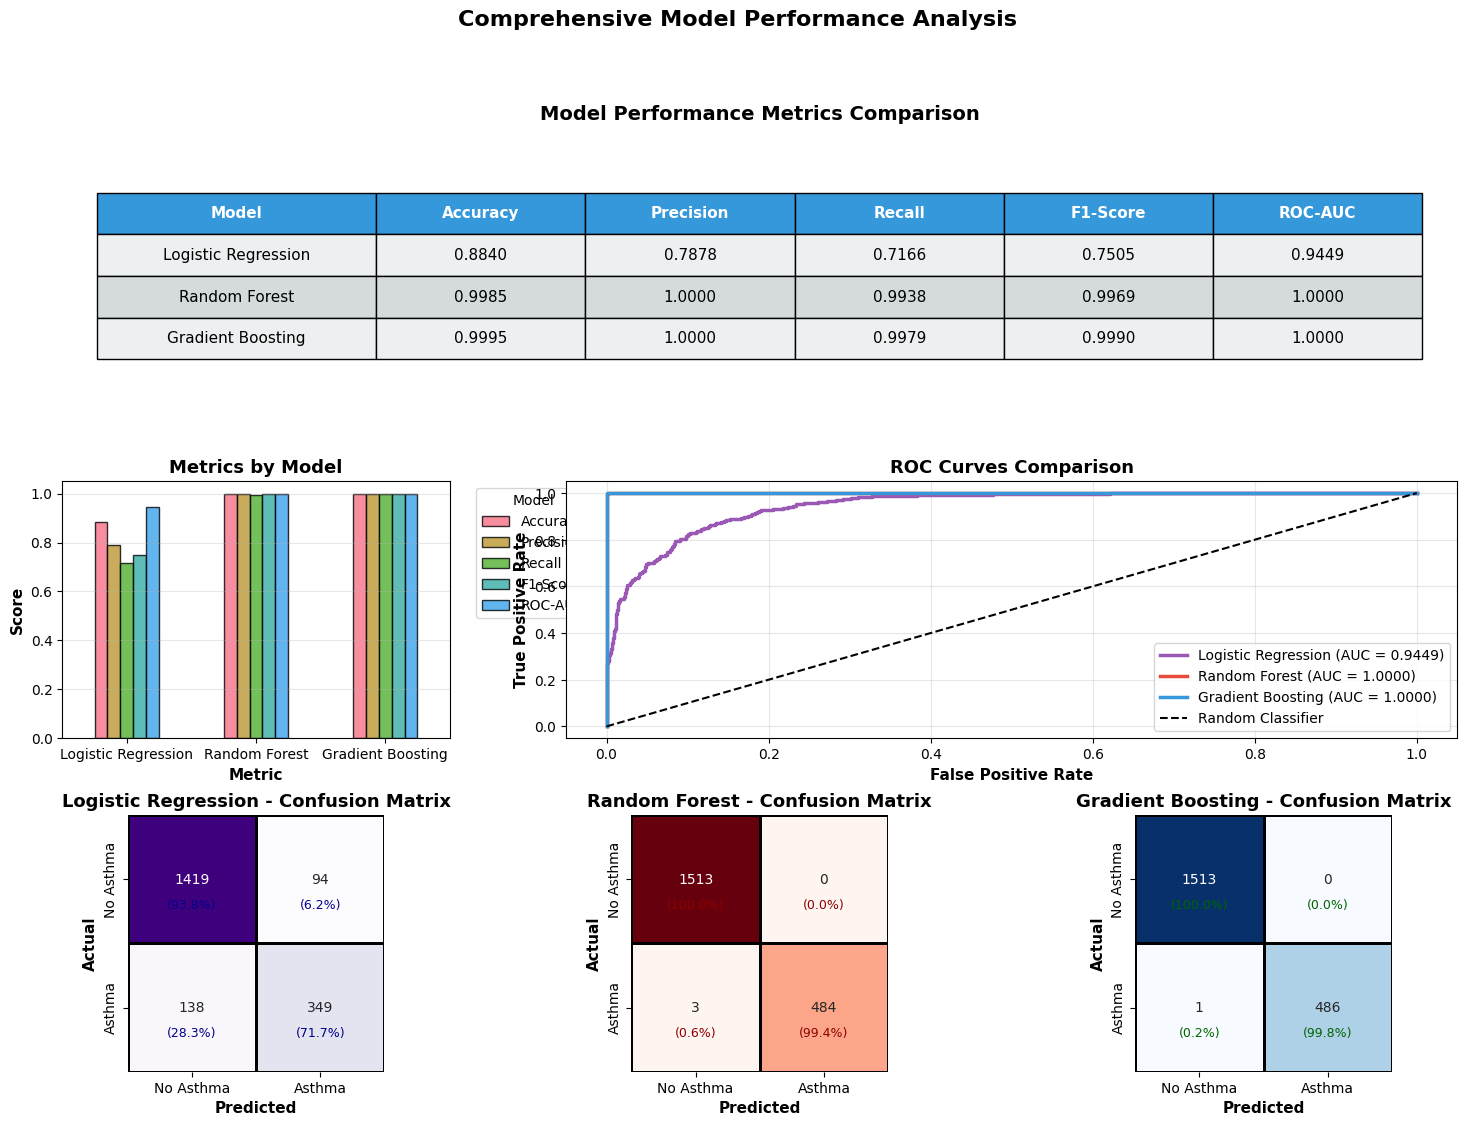


DETAILED MODEL COMPARISON

Logistic Regression:
----------------------------------------
  Accuracy       : 0.884000
  Precision      : 0.787810
  Recall         : 0.716632
  F1-Score       : 0.750538
  ROC-AUC        : 0.944929

Random Forest:
----------------------------------------
  Accuracy       : 0.998500
  Precision      : 1.000000
  Recall         : 0.993840
  F1-Score       : 0.996910
  ROC-AUC        : 0.999996

Gradient Boosting:
----------------------------------------
  Accuracy       : 0.999500
  Precision      : 1.000000
  Recall         : 0.997947
  F1-Score       : 0.998972
  ROC-AUC        : 1.000000



In [16]:
# Comprehensive model performance visualization
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Aggregate all key metrics for all three models
metrics = {
    'Logistic Regression': {
        'Accuracy': accuracy_score(y_test, y_pred_lr),
        'Precision': precision_score(y_test, y_pred_lr),
        'Recall': recall_score(y_test, y_pred_lr),
        'F1-Score': f1_score(y_test, y_pred_lr),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba_lr)
    },
    'Random Forest': {
        'Accuracy': accuracy_score(y_test, y_pred_rf),
        'Precision': precision_score(y_test, y_pred_rf),
        'Recall': recall_score(y_test, y_pred_rf),
        'F1-Score': f1_score(y_test, y_pred_rf),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba_rf)
    },
    'Gradient Boosting': {
        'Accuracy': accuracy_score(y_test, y_pred_gb),
        'Precision': precision_score(y_test, y_pred_gb),
        'Recall': recall_score(y_test, y_pred_gb),
        'F1-Score': f1_score(y_test, y_pred_gb),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba_gb)
    }
}

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Tabular summary of metrics
ax1 = fig.add_subplot(gs[0, :])
ax1.axis('tight')
ax1.axis('off')

metrics_df = pd.DataFrame(metrics).T
header = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
table_rows = [header]
for model in metrics_df.index:
    row = [model] + [f"{val:.4f}" for val in metrics_df.loc[model]]
    table_rows.append(row)

table = ax1.table(cellText=table_rows, cellLoc='center', loc='center', colWidths=[0.2, 0.15, 0.15, 0.15, 0.15, 0.15])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

for col_idx in range(len(header)):
    cell = table[(0, col_idx)]
    cell.set_facecolor('#3498db')
    cell.set_text_props(weight='bold', color='white')

row_colors = ['#ecf0f1', '#d5dbdb', '#ecf0f1']
for row_idx in range(1, len(table_rows)):
    for col_idx in range(len(header)):
        table[(row_idx, col_idx)].set_facecolor(row_colors[row_idx - 1])

ax1.set_title('Model Performance Metrics Comparison', fontsize=14, weight='bold', pad=20)

# 2. Bar chart comparison of metrics
ax2 = fig.add_subplot(gs[1, 0])
metrics_df.plot(kind='bar', ax=ax2, alpha=0.8, edgecolor='black', rot=0)
ax2.set_ylabel('Score', fontsize=11, weight='bold')
ax2.set_xlabel('Metric', fontsize=11, weight='bold')
ax2.set_title('Metrics by Model', fontsize=13, weight='bold')
ax2.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(axis='y', alpha=0.3)

# 3. ROC Curves Comparison
ax3 = fig.add_subplot(gs[1, 1:])
ax3.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_pred_proba_lr):.4f})', linewidth=2.5, color='#9b59b6')
ax3.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_pred_proba_rf):.4f})', linewidth=2.5, color='#e74c3c')
ax3.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {roc_auc_score(y_test, y_pred_proba_gb):.4f})', linewidth=2.5, color='#3498db')
ax3.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random Classifier')
ax3.set_xlabel('False Positive Rate', fontsize=11, weight='bold')
ax3.set_ylabel('True Positive Rate', fontsize=11, weight='bold')
ax3.set_title('ROC Curves Comparison', fontsize=13, weight='bold')
ax3.legend(loc='lower right')
ax3.grid(alpha=0.3)

# 4. Confusion matrix - Logistic Regression
ax4 = fig.add_subplot(gs[2, 0])
cm_lr_percent = cm_lr.astype(float) / cm_lr.sum(axis=1, keepdims=True) * 100
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Purples', cbar=False, ax=ax4, square=True, linewidths=2, linecolor='black')
for i in range(cm_lr.shape[0]):
    for j in range(cm_lr.shape[1]):
        ax4.text(j + 0.5, i + 0.7, f'({cm_lr_percent[i, j]:.1f}%)', ha='center', va='center', fontsize=9, color='darkblue')
ax4.set_xlabel('Predicted', fontsize=11, weight='bold')
ax4.set_ylabel('Actual', fontsize=11, weight='bold')
ax4.set_title('Logistic Regression - Confusion Matrix', fontsize=13, weight='bold')
ax4.set_xticklabels(['No Asthma', 'Asthma'])
ax4.set_yticklabels(['No Asthma', 'Asthma'])

# 5. Confusion matrix - Random Forest
ax5 = fig.add_subplot(gs[2, 1])
cm_rf_percent = cm_rf.astype(float) / cm_rf.sum(axis=1, keepdims=True) * 100
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Reds', cbar=False, ax=ax5, square=True, linewidths=2, linecolor='black')
for i in range(cm_rf.shape[0]):
    for j in range(cm_rf.shape[1]):
        ax5.text(j + 0.5, i + 0.7, f'({cm_rf_percent[i, j]:.1f}%)', ha='center', va='center', fontsize=9, color='darkred')
ax5.set_xlabel('Predicted', fontsize=11, weight='bold')
ax5.set_ylabel('Actual', fontsize=11, weight='bold')
ax5.set_title('Random Forest - Confusion Matrix', fontsize=13, weight='bold')
ax5.set_xticklabels(['No Asthma', 'Asthma'])
ax5.set_yticklabels(['No Asthma', 'Asthma'])

# 6. Confusion matrix - Gradient Boosting
ax6 = fig.add_subplot(gs[2, 2])
cm_gb_percent = cm_gb.astype(float) / cm_gb.sum(axis=1, keepdims=True) * 100
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax6, square=True, linewidths=2, linecolor='black')
for i in range(cm_gb.shape[0]):
    for j in range(cm_gb.shape[1]):
        ax6.text(j + 0.5, i + 0.7, f'({cm_gb_percent[i, j]:.1f}%)', ha='center', va='center', fontsize=9, color='darkgreen')
ax6.set_xlabel('Predicted', fontsize=11, weight='bold')
ax6.set_ylabel('Actual', fontsize=11, weight='bold')
ax6.set_title('Gradient Boosting - Confusion Matrix', fontsize=13, weight='bold')
ax6.set_xticklabels(['No Asthma', 'Asthma'])
ax6.set_yticklabels(['No Asthma', 'Asthma'])

plt.suptitle('Comprehensive Model Performance Analysis', fontsize=16, weight='bold', y=0.995)
plt.show()

print("\n" + "=" * 80)
print("DETAILED MODEL COMPARISON")
print("=" * 80)
for model, model_metrics in metrics.items():
    print(f"\n{model}:")
    print("-" * 40)
    for metric_name, metric_value in model_metrics.items():
        print(f"  {metric_name:15s}: {metric_value:.6f}")
print("\n" + "=" * 80)

## Feature Importance

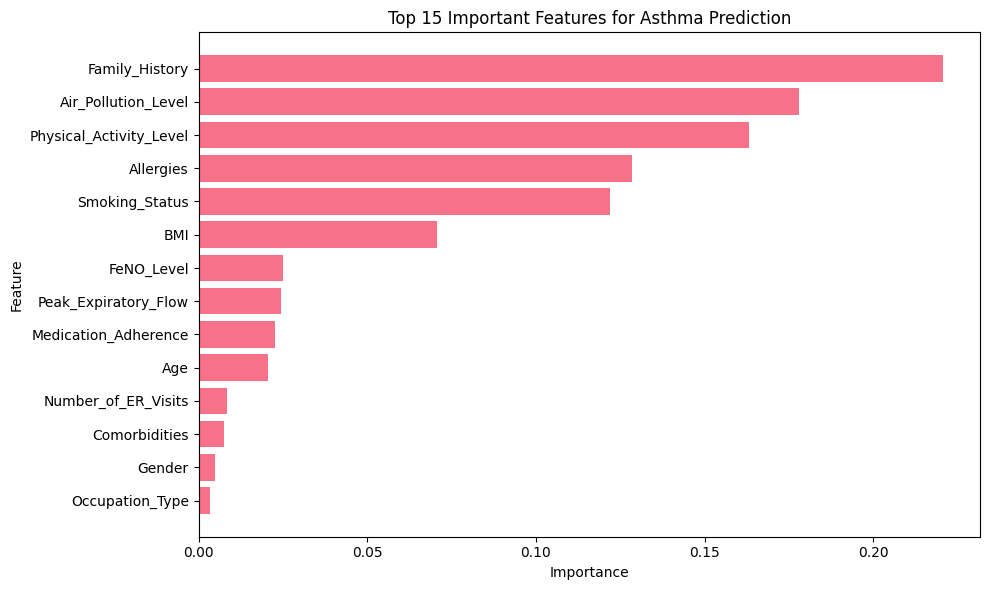

In [ ]:
# Get feature importance from Random Forest
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance['importance'])
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 15 Important Features for Asthma Prediction')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Advanced Feature Importance and Clinical Insights

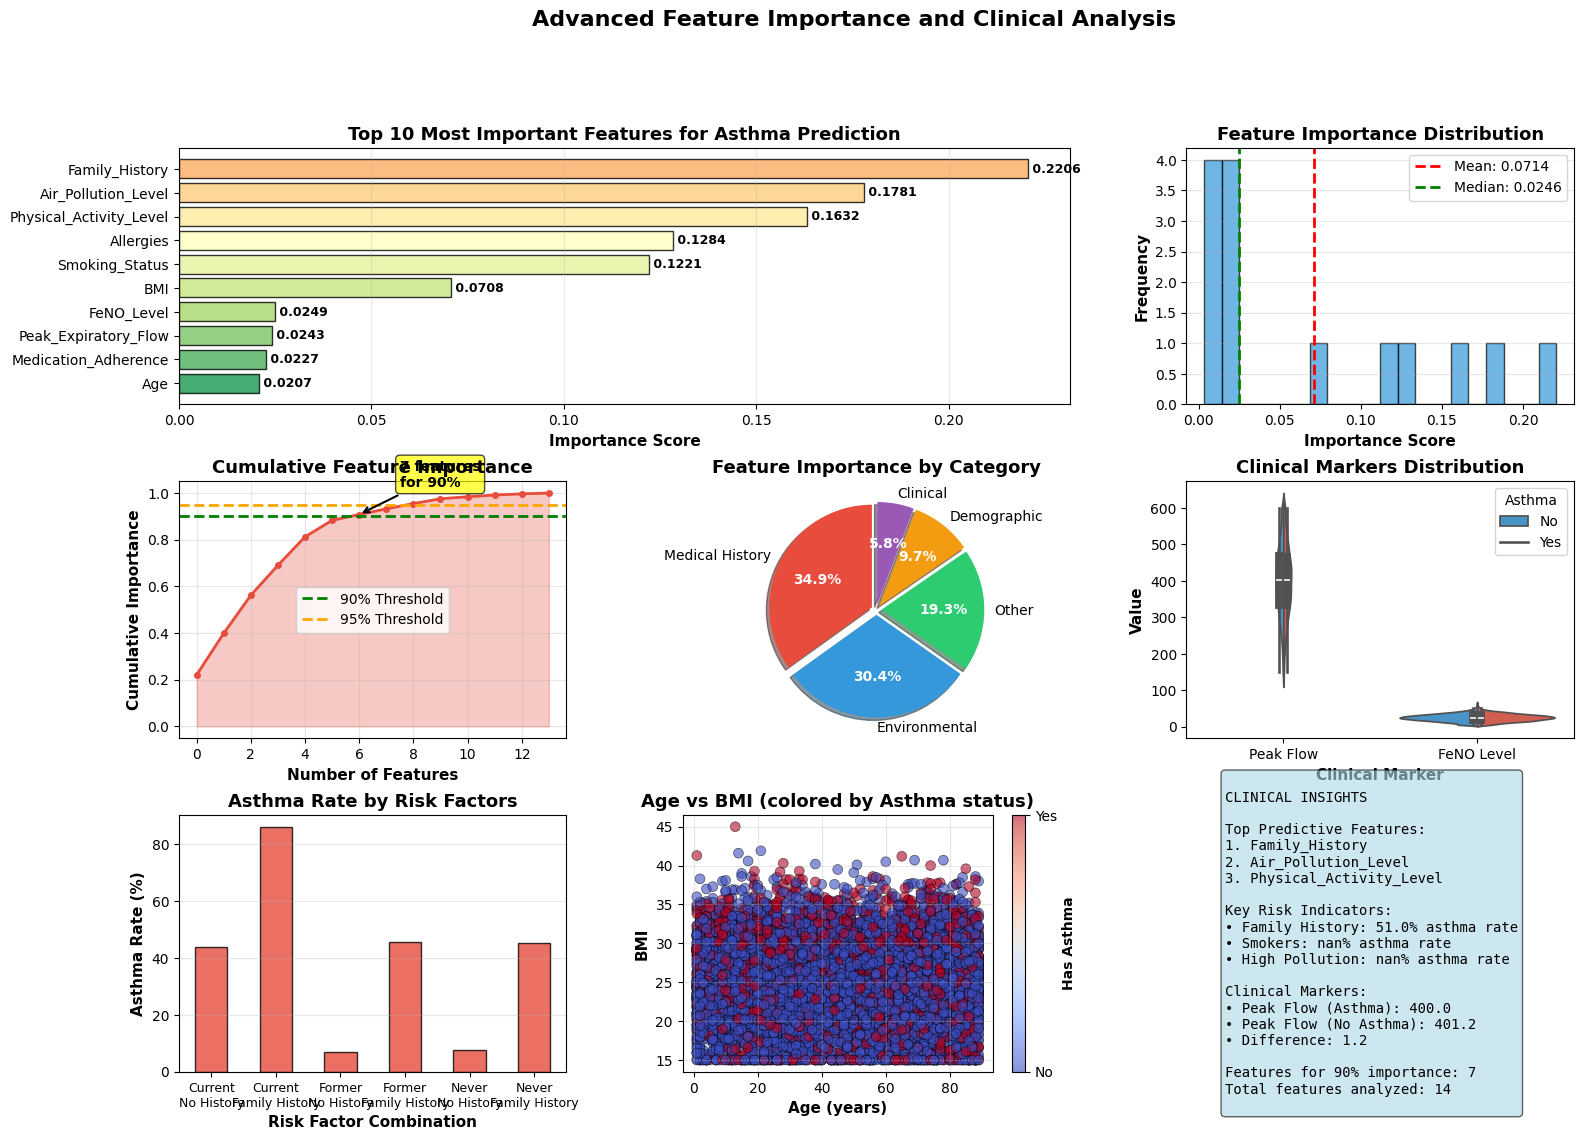


COMPLETE FEATURE IMPORTANCE RANKING
Family_History                     : 0.220591 (Medical History)
Air_Pollution_Level                : 0.178092 (Environmental)
Physical_Activity_Level            : 0.163153 (Other)
Allergies                          : 0.128433 (Medical History)
Smoking_Status                     : 0.122054 (Environmental)
BMI                                : 0.070761 (Demographic)
FeNO_Level                         : 0.024902 (Clinical)
Peak_Expiratory_Flow               : 0.024306 (Clinical)
Medication_Adherence               : 0.022667 (Other)
Age                                : 0.020729 (Demographic)
Number_of_ER_Visits                : 0.008376 (Clinical)
Comorbidities                      : 0.007561 (Other)
Gender                             : 0.005021 (Demographic)
Occupation_Type                    : 0.003355 (Environmental)

Number of features needed for 90% cumulative importance: 7
Number of features needed for 95% cumulative importance: 9


In [ ]:
# Advanced feature importance analysis
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Normalize column names for easier downstream handling
fi_extended = feature_importance.rename(columns={
    'feature': 'Feature',
    'importance': 'Importance'
}).copy()
fi_extended['Feature'] = fi_extended['Feature'].astype(str)

# 1. Top 10 most important features
ax1 = fig.add_subplot(gs[0, :2])
top_features = fi_extended.nlargest(10, 'Importance')
colors_feat = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(top_features)))
bars = ax1.barh(range(len(top_features)), top_features['Importance'],
                color=colors_feat, alpha=0.8, edgecolor='black')
ax1.set_yticks(range(len(top_features)))
ax1.set_yticklabels(top_features['Feature'], fontsize=10)
ax1.set_xlabel('Importance Score', fontsize=11, weight='bold')
ax1.set_title('Top 10 Most Important Features for Asthma Prediction', fontsize=13, weight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

for i, (_, row) in enumerate(top_features.iterrows()):
    ax1.text(row['Importance'], i, f" {row['Importance']:.4f}",
             va='center', fontsize=9, weight='bold')

# 2. Feature importance distribution
ax2 = fig.add_subplot(gs[0, 2])
ax2.hist(fi_extended['Importance'], bins=20, color='#3498db',
         alpha=0.7, edgecolor='black')
ax2.axvline(fi_extended['Importance'].mean(), color='red',
            linestyle='--', linewidth=2, label=f'Mean: {fi_extended["Importance"].mean():.4f}')
ax2.axvline(fi_extended['Importance'].median(), color='green',
            linestyle='--', linewidth=2, label=f'Median: {fi_extended["Importance"].median():.4f}')
ax2.set_xlabel('Importance Score', fontsize=11, weight='bold')
ax2.set_ylabel('Frequency', fontsize=11, weight='bold')
ax2.set_title('Feature Importance Distribution', fontsize=13, weight='bold')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Cumulative importance
ax3 = fig.add_subplot(gs[1, 0])
sorted_importance_values = fi_extended.sort_values('Importance', ascending=False)['Importance'].to_numpy()
cumulative_importance = np.cumsum(sorted_importance_values)
ax3.plot(range(len(cumulative_importance)), cumulative_importance,
        marker='o', linewidth=2, markersize=4, color='#e74c3c')
ax3.axhline(y=0.90, color='green', linestyle='--', linewidth=2,
           label='90% Threshold')
ax3.axhline(y=0.95, color='orange', linestyle='--', linewidth=2,
           label='95% Threshold')
ax3.fill_between(range(len(cumulative_importance)), cumulative_importance,
                 alpha=0.3, color='#e74c3c')
ax3.set_xlabel('Number of Features', fontsize=11, weight='bold')
ax3.set_ylabel('Cumulative Importance', fontsize=11, weight='bold')
ax3.set_title('Cumulative Feature Importance', fontsize=13, weight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

threshold_90 = 0.90
threshold_95 = 0.95

if len(cumulative_importance) == 0:
    coverage_total = 0.0
    n_features_90 = 0
    n_features_95 = 0
else:
    coverage_total = cumulative_importance[-1]
    if coverage_total >= threshold_90:
        n_features_90 = int(np.searchsorted(cumulative_importance, threshold_90, side='left')) + 1
    else:
        n_features_90 = len(cumulative_importance)
    if coverage_total >= threshold_95:
        n_features_95 = int(np.searchsorted(cumulative_importance, threshold_95, side='left')) + 1
    else:
        n_features_95 = len(cumulative_importance)

if len(cumulative_importance) > 0:
    idx_to_mark = min(n_features_90 - 1, len(cumulative_importance) - 1) if n_features_90 > 0 else len(cumulative_importance) - 1
    annotation_text = (
        f'{n_features_90} features\nfor 90%'
        if coverage_total >= threshold_90 and n_features_90 > 0
        else f'Top {len(cumulative_importance)} features\nreach {coverage_total*100:.1f}%'
    )
    ax3.annotate(
        annotation_text,
        xy=(idx_to_mark, cumulative_importance[idx_to_mark]),
        xytext=(idx_to_mark + 1.5, min(1.05, cumulative_importance[idx_to_mark] + 0.12)),
        arrowprops=dict(arrowstyle='->', color='black', lw=1.5),
        fontsize=10, weight='bold', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7)
    )

# 4. Feature importance by category
ax4 = fig.add_subplot(gs[1, 1])
clinical_features = ['Peak_Expiratory_Flow', 'FeNO_Level', 'Number_of_ER_Visits']
demographic_features = ['Age', 'BMI', 'Gender']
environmental_features = ['Air_Pollution_Level', 'Smoking_Status', 'Occupation_Type']
medical_history = ['Family_History', 'Allergies', 'Respiratory_Infections_Per_Year']

categories = []
for feat in fi_extended['Feature']:
    if feat in clinical_features:
        categories.append('Clinical')
    elif feat in demographic_features:
        categories.append('Demographic')
    elif feat in environmental_features:
        categories.append('Environmental')
    elif feat in medical_history:
        categories.append('Medical History')
    else:
        categories.append('Other')

fi_extended['Category'] = categories
category_importance = fi_extended.groupby('Category')['Importance'].sum().sort_values(ascending=False)

colors_cat = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6'][:len(category_importance)]
wedges, texts, autotexts = ax4.pie(category_importance.values, labels=category_importance.index,
                                   autopct='%1.1f%%', colors=colors_cat,
                                   startangle=90, explode=[0.05]*len(category_importance), shadow=True)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_weight('bold')
    autotext.set_fontsize(10)
ax4.set_title('Feature Importance by Category', fontsize=13, weight='bold')

# 5. Clinical markers comparison
ax5 = fig.add_subplot(gs[1, 2])
clinical_data = df[['Peak_Expiratory_Flow', 'FeNO_Level', 'Has_Asthma']].copy()
clinical_melted = clinical_data.melt(id_vars='Has_Asthma',
                                      value_vars=['Peak_Expiratory_Flow', 'FeNO_Level'])
sns.violinplot(data=clinical_melted, x='variable', y='value', hue='Has_Asthma',
              split=True, ax=ax5, palette=['#3498db', '#e74c3c'])
ax5.set_xlabel('Clinical Marker', fontsize=11, weight='bold')
ax5.set_ylabel('Value', fontsize=11, weight='bold')
ax5.set_title('Clinical Markers Distribution', fontsize=13, weight='bold')
ax5.set_xticks(range(len(clinical_melted['variable'].unique())))
ax5.set_xticklabels(['Peak Flow', 'FeNO Level'])
ax5.legend(title='Asthma', labels=['No', 'Yes'])

# 6. Risk factor analysis
ax6 = fig.add_subplot(gs[2, 0])
risk_factors = df.groupby(['Smoking_Status', 'Family_History', 'Has_Asthma']).size().unstack(fill_value=0)
risk_factors_pct = risk_factors.div(risk_factors.sum(axis=1), axis=0) * 100
risk_factors_pct[1].plot(kind='bar', ax=ax6, color='#e74c3c', alpha=0.8, edgecolor='black')
ax6.set_xlabel('Risk Factor Combination', fontsize=11, weight='bold')
ax6.set_ylabel('Asthma Rate (%)', fontsize=11, weight='bold')
ax6.set_title('Asthma Rate by Risk Factors', fontsize=13, weight='bold')

risk_labels = []
for smoking_status, family_history in risk_factors_pct.index:
    smoke_label = str(smoking_status).title()
    history_label = 'Family History' if family_history == 1 else 'No History'
    risk_labels.append(f'{smoke_label}\n{history_label}')
ax6.set_xticklabels(risk_labels, rotation=0, fontsize=9)
ax6.grid(axis='y', alpha=0.3)

# 7. Age and BMI interaction
ax7 = fig.add_subplot(gs[2, 1])
scatter = ax7.scatter(df['Age'], df['BMI'], c=df['Has_Asthma'],
                     cmap='coolwarm', alpha=0.6, s=50, edgecolor='black', linewidth=0.5)
ax7.set_xlabel('Age (years)', fontsize=11, weight='bold')
ax7.set_ylabel('BMI', fontsize=11, weight='bold')
ax7.set_title('Age vs BMI (colored by Asthma status)', fontsize=13, weight='bold')
cbar = plt.colorbar(scatter, ax=ax7)
cbar.set_label('Has Asthma', fontsize=10, weight='bold')
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['No', 'Yes'])
ax7.grid(alpha=0.3)

# 8. Clinical insights summary
ax8 = fig.add_subplot(gs[2, 2])
ax8.axis('off')

asthma_with_family_history = df[df['Family_History']==1]['Has_Asthma'].mean() * 100
asthma_smokers = df[df['Smoking_Status']==1]['Has_Asthma'].mean() * 100
high_pollution_asthma = df[df['Air_Pollution_Level']==2]['Has_Asthma'].mean() * 100
avg_peak_flow_asthma = df[df['Has_Asthma']==1]['Peak_Expiratory_Flow'].mean()
avg_peak_flow_no_asthma = df[df['Has_Asthma']==0]['Peak_Expiratory_Flow'].mean()

feature_coverage_text = (
    f'Features for 90% importance: {n_features_90}' if coverage_total >= threshold_90 and len(cumulative_importance) > 0
    else f'Top {len(cumulative_importance)} features cover {coverage_total*100:.1f}% importance'
)

insights_text = f"""
CLINICAL INSIGHTS

Top Predictive Features:
1. {top_features.iloc[0]['Feature'] if not top_features.empty else 'N/A'}
2. {top_features.iloc[1]['Feature'] if len(top_features) > 1 else 'N/A'}
3. {top_features.iloc[2]['Feature'] if len(top_features) > 2 else 'N/A'}

Key Risk Indicators:
• Family History: {asthma_with_family_history:.1f}% asthma rate
• Smokers: {asthma_smokers:.1f}% asthma rate
• High Pollution: {high_pollution_asthma:.1f}% asthma rate

Clinical Markers:
• Peak Flow (Asthma): {avg_peak_flow_asthma:.1f}
• Peak Flow (No Asthma): {avg_peak_flow_no_asthma:.1f}
• Difference: {avg_peak_flow_no_asthma - avg_peak_flow_asthma:.1f}

{feature_coverage_text}
Total features analyzed: {len(fi_extended)}
"""

ax8.text(0.1, 0.5, insights_text, fontsize=10, verticalalignment='center',
         family='monospace', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.6))

plt.suptitle('Advanced Feature Importance and Clinical Analysis', fontsize=16, weight='bold', y=0.995)
plt.show()

# Print detailed feature importance
print("\n" + "="*80)
print("COMPLETE FEATURE IMPORTANCE RANKING")
print("="*80)
for _, row in fi_extended.sort_values('Importance', ascending=False).iterrows():
    print(f"{row['Feature']:35s}: {row['Importance']:.6f} ({row['Category']})")
print("\n" + "="*80)
print(f"Number of features needed for 90% cumulative importance: {n_features_90}")
print(f"Number of features needed for 95% cumulative importance: {n_features_95}")
print("="*80)